In [ ]:
# required libraries
import os                                           #for loading data
import cv2                                          #for reading data and for transformations
import matplotlib.pyplot as plt                     #for plotting and showing image
import numpy as np                                  #for any numerical operations 
import pandas as pd
import math

In [ ]:
import numpy as np
import cv2
from skimage.transform import hough_circle, hough_circle_peaks

def IrisLocalization(eye):
    blured = cv2.bilateralFilter(eye,9,100,100)
    Xp = blured.sum(axis=0).argmin()
    Yp = blured.sum(axis=1).argmin()
    x = blured[max(Yp - 60,0):min(Yp + 60,280), max(Xp - 60,0):min(Xp + 60,320)].sum(axis=0).argmin()
    y = blured[max(Yp - 60,0):min(Yp + 60,280), max(Xp - 60,0):min(Xp + 60,320)].sum(axis=1).argmin()
    Xp = max(Xp - 60,0)+x
    Yp = max(Yp - 60,0)+y
    if Xp >= 100 and Yp >= 80: 
        blur = cv2.GaussianBlur(eye[Yp - 60:Yp + 60, Xp - 60:Xp + 60],(5,5),0)
        pupil_circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT, dp=1.2,minDist=200,param1=200,param2=12,minRadius=15,maxRadius=80)
        xp, yp, rp = np.round(pupil_circles[0][0]).astype("int")
        xp = Xp - 60 + xp
        yp = Yp - 60 + yp
    else:
        pupil_circles = cv2.HoughCircles(blured, cv2.HOUGH_GRADIENT, 4, 280, minRadius = 25, maxRadius=55, param2=51)
        xp, yp, rp = np.round(pupil_circles[0][0]).astype("int")
    eye_copy = eye.copy()
    rp = rp+7 #slightly enlarge the pupil radius makes a better result
    blured_copy = cv2.medianBlur(eye_copy, 11)
    blured_copy = cv2.medianBlur(blured_copy, 11)
    blured_copy = cv2.medianBlur(blured_copy, 11)
    eye_edges = cv2.Canny(blured_copy, threshold1 = 15, threshold2 = 30, L2gradient=True)
    eye_edges[:,xp - rp - 30:xp + rp + 30] = 0
    
    hough_radii = np.arange(rp+45, 150, 2)
    hough_res = hough_circle(eye_edges, hough_radii)
    accums, xi, yi, ri = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
    iris = []
    iris.extend(xi)
    iris.extend(yi)
    iris.extend(ri)
    if ((iris[0] - xp) ** 2+(iris[1]-yp)**2) ** 0.5 > rp* 0.3: # if the distance of iris center and pupil center is too far, we fix the iris center.
        iris[0] = xp
        iris[1] = yp
    return np.array(iris), np.array([xp,yp,rp-4])

In [ ]:
import math
import numpy as np
def IrisNormalization(image,inner_circle,outer_circle ):
    localized_img=image
    row=64
    col=512
    normalized_iris=np.zeros(shape=(64,512))
    inner_y=inner_circle[0]  #height
    inner_x=inner_circle[1]  #width
    outer_y=outer_circle[0]
    outer_x=outer_circle[1]
    angle=2.0*math.pi/col
    inner_boundary_x = np.zeros(shape=(1,col))
    inner_boundary_y = np.zeros(shape=(1,col))
    outer_boundary_x = np.zeros(shape=(1,col))
    outer_boundary_y = np.zeros(shape=(1,col))
    for j in range(col):


        inner_boundary_x[0][j]=inner_circle[0]+inner_circle[2]*math.cos(angle*(j))
        inner_boundary_y[0][j]=inner_circle[1]+inner_circle[2]*math.sin(angle*(j))
        
        outer_boundary_x[0][j]=outer_circle[0]+outer_circle[2]*math.cos(angle*(j))
        outer_boundary_y[0][j]=outer_circle[1]+outer_circle[2]*math.sin(angle*(j))
        
    for j in range (512):
        for i in range (64):
             normalized_iris[i][j]=localized_img[min(int(int(inner_boundary_y[0][j])
                                   +(int(outer_boundary_y[0][j])-int(inner_boundary_y[0][j]))*(i/64.0)),localized_img.shape[0]-1)][min(int(int(inner_boundary_x[0][j])
                                   +(int(outer_boundary_x[0][j])-int(inner_boundary_x[0][j]))
                                   *(i/64.0)),localized_img.shape[1]-1)]

    res_image=255-normalized_iris
    return res_image

In [ ]:
from skimage.filters.rank import equalize
from skimage.morphology import disk
import numpy as np
def ImageEnhancement(normalized_iris):
    row=64
    col=512
    normalized_iris = normalized_iris.astype(np.uint8)
    
    
    enhanced_image=normalized_iris
     
    enhanced_image = equalize(enhanced_image, disk(32))
    
    roi = enhanced_image[0:48,:]
    return roi

IndexError: ignored

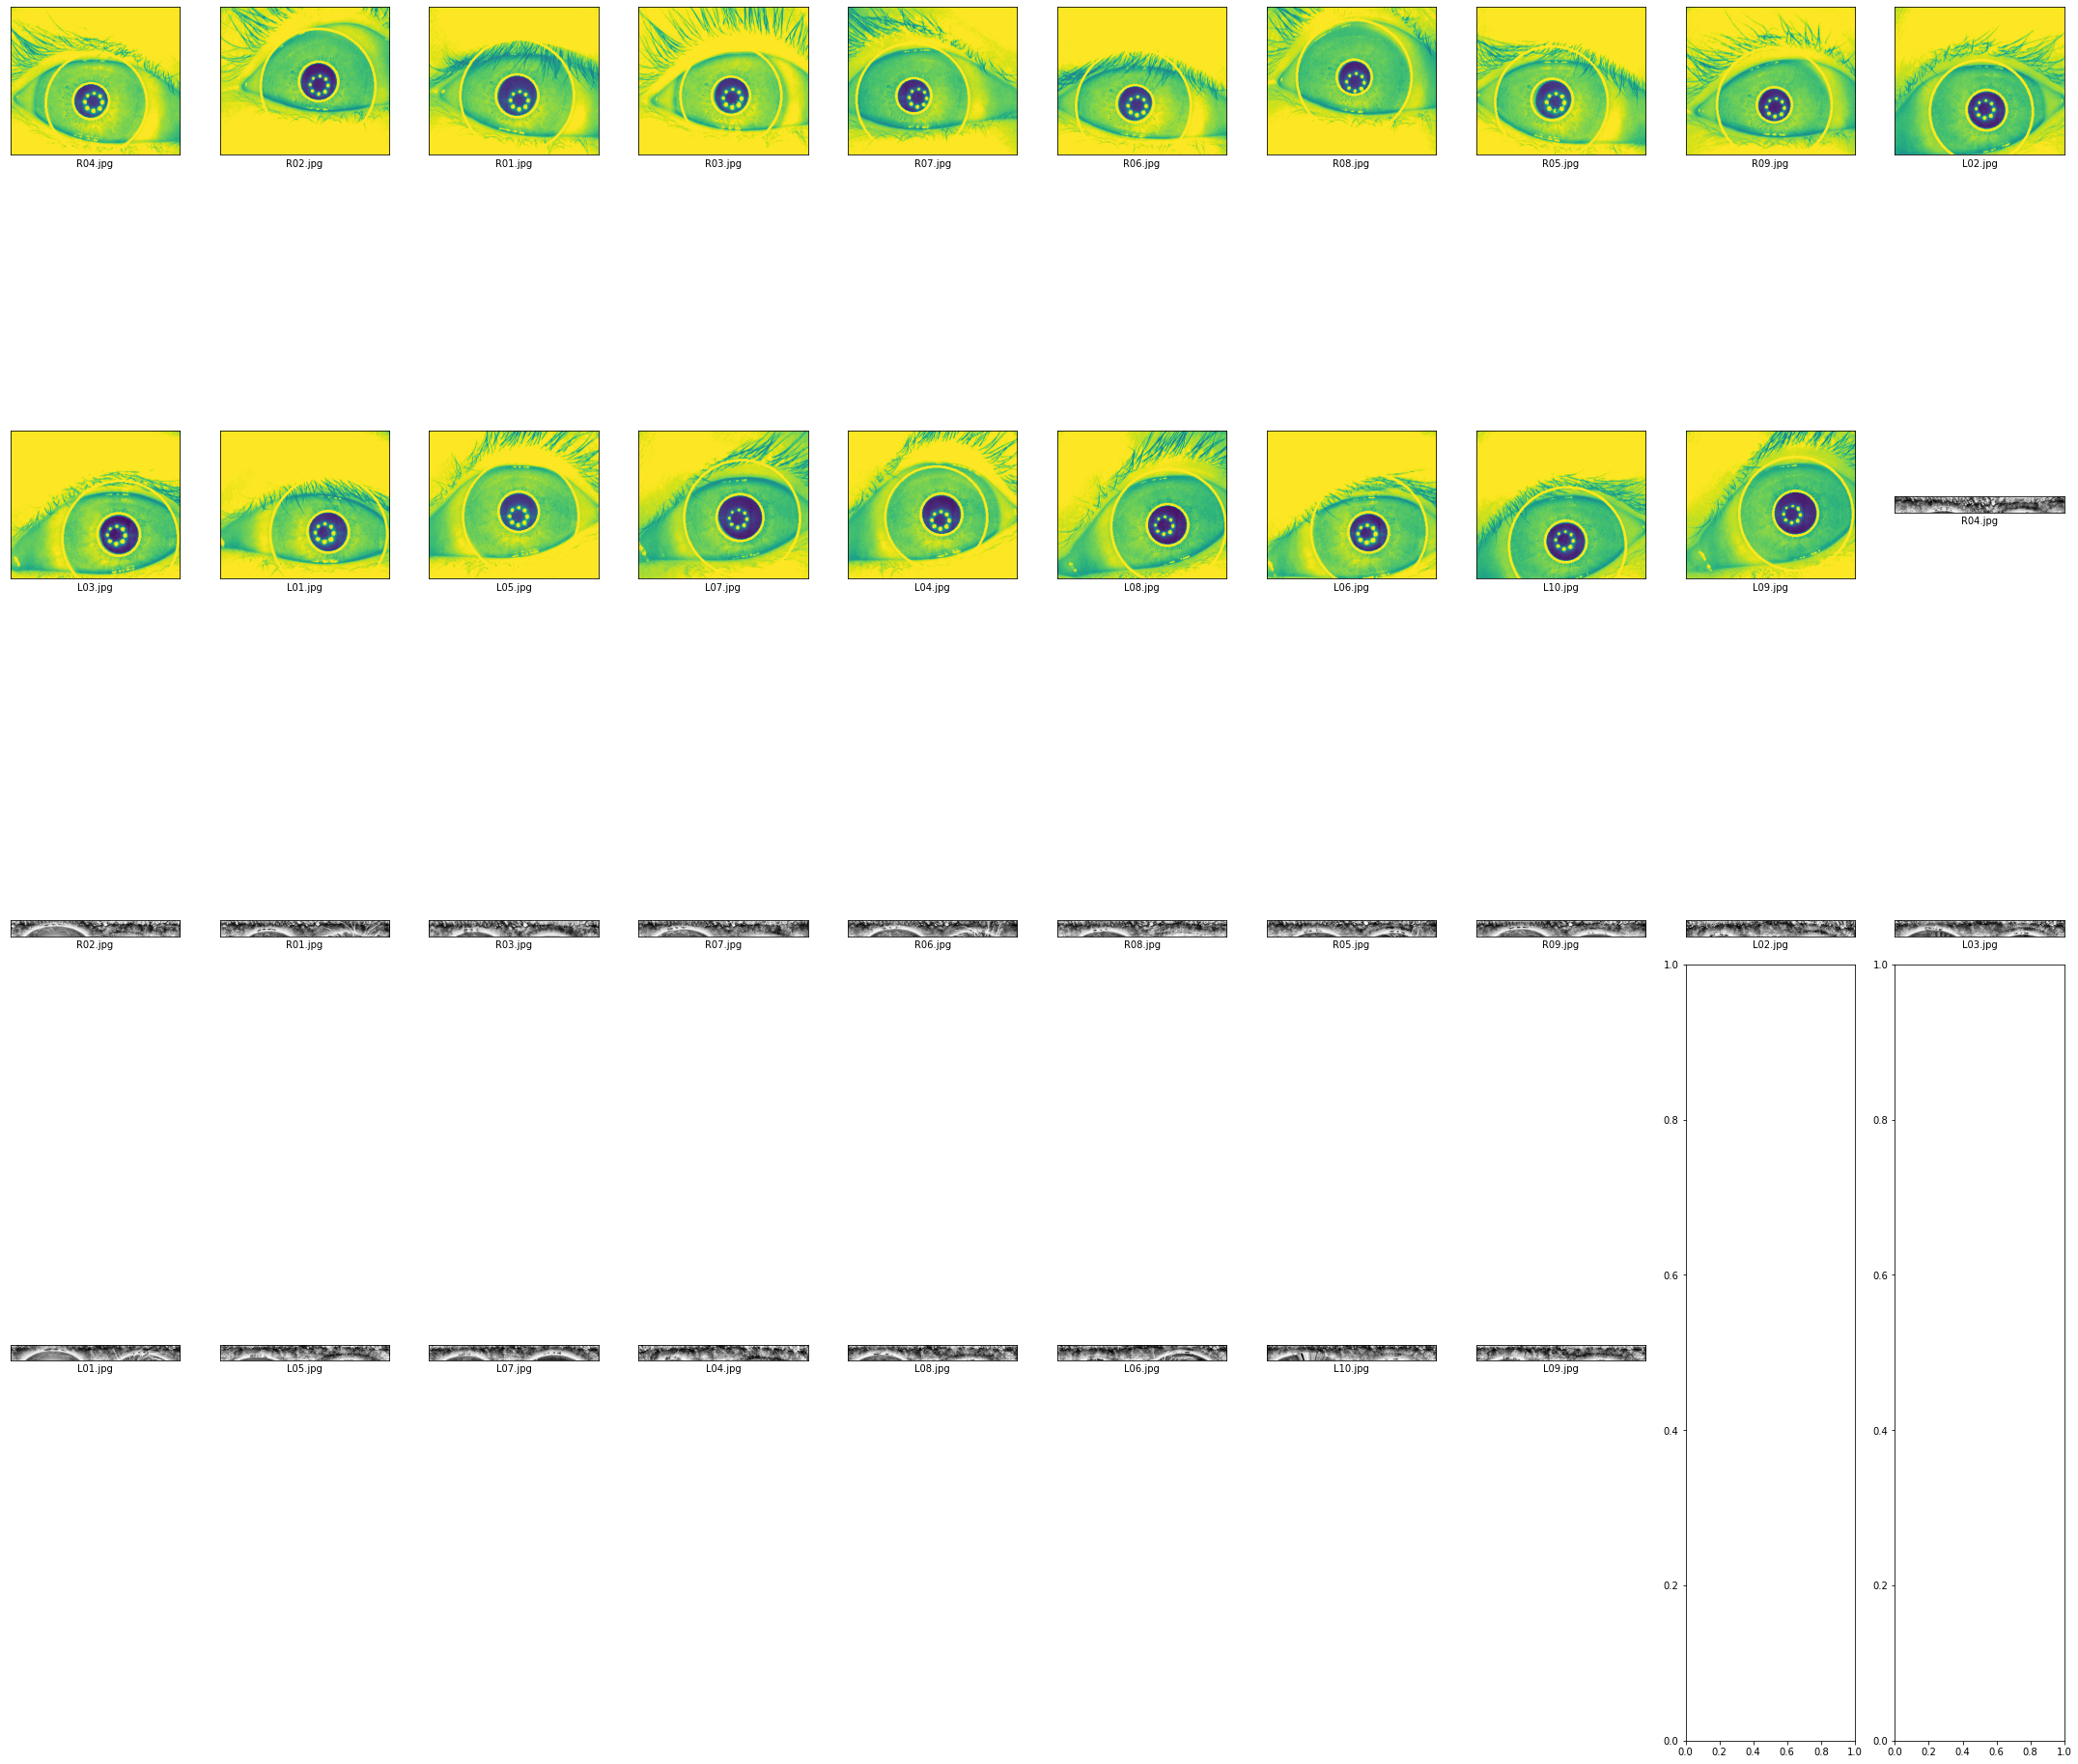

In [ ]:
path = '/content/drive/MyDrive/DATABASES/CASIA-Iris-Interval/229'  # path of the data file
data = []
label = []
normd = []
for fol in os.listdir(path):
  if fol == 'L' or fol =='R':
    path_img = os.path.join(path,fol)  
    for img in os.listdir(path_img):  
      imagep = cv2.imread(os.path.join(path_img,img))                
      eye = cv2.cvtColor(imagep, cv2.COLOR_BGR2GRAY)
      label.append(img[5:]) 
      ik,ci = IrisLocalization(eye)
      x,y,r = ik
      x1,y1,r1 = ci
      dra1 = eye.copy()
      cv2.circle(dra1, (x, y), r, color=(255, 0, 0), thickness=3)
      cv2.circle(dra1, (x1, y1), r1, color=(255, 0, 0), thickness=3)
      data.append(dra1)
      iris, pupil = ik,ci
      normalized = IrisNormalization(eye, pupil, iris)
      ROI = ImageEnhancement(normalized)
      ROI = cv2.cvtColor(ROI,cv2.COLOR_GRAY2RGB)
      normd.append(ROI)
      

data = np.array(data)
label = np.array(label)
normd = np.array(normd)
fig, ax = plt.subplots(4,10,figsize = (30,30))

c=0
c1=0
for i ,axi in enumerate(ax.flat):
  if i<=18:
    axi.imshow(data[i])
    axi.set(xticks=[],yticks=[],
            xlabel=label[i])
    fig.tight_layout()
    c=c+1
  else:
    axi.imshow(normd[c1])
    axi.set(xticks=[],yticks=[],
            xlabel=label[c1])
    fig.tight_layout()
    c1=c1+1